Using device: cpu

Scaler successfully fitted on training data and saved to scaler.pkl

--- Starting Experiments on 5 Failure Types ---

===== Training with Loss: CrossEntropy, Optimizer: SGD_momentum =====
Epoch [10/50], Train Loss: 0.1241, Val Loss: 0.2998, Train Acc: 95.88%, Val Acc: 84.29%
Epoch [20/50], Train Loss: 0.0534, Val Loss: 0.2683, Train Acc: 98.35%, Val Acc: 88.57%
Epoch [30/50], Train Loss: 0.0347, Val Loss: 0.2674, Train Acc: 98.97%, Val Acc: 90.00%
Epoch [40/50], Train Loss: 0.0241, Val Loss: 0.3726, Train Acc: 99.43%, Val Acc: 88.57%
Epoch [50/50], Train Loss: 0.0150, Val Loss: 0.2973, Train Acc: 99.55%, Val Acc: 91.43%
Final Validation Accuracy: 91.4286

===== Training with Loss: CrossEntropy, Optimizer: Adam =====
Epoch [10/50], Train Loss: 0.0507, Val Loss: 0.2809, Train Acc: 98.37%, Val Acc: 88.57%
Epoch [20/50], Train Loss: 0.0246, Val Loss: 0.3025, Train Acc: 99.18%, Val Acc: 90.00%
Epoch [30/50], Train Loss: 0.0150, Val Loss: 0.3243, Train Acc: 99.52%, Val Acc

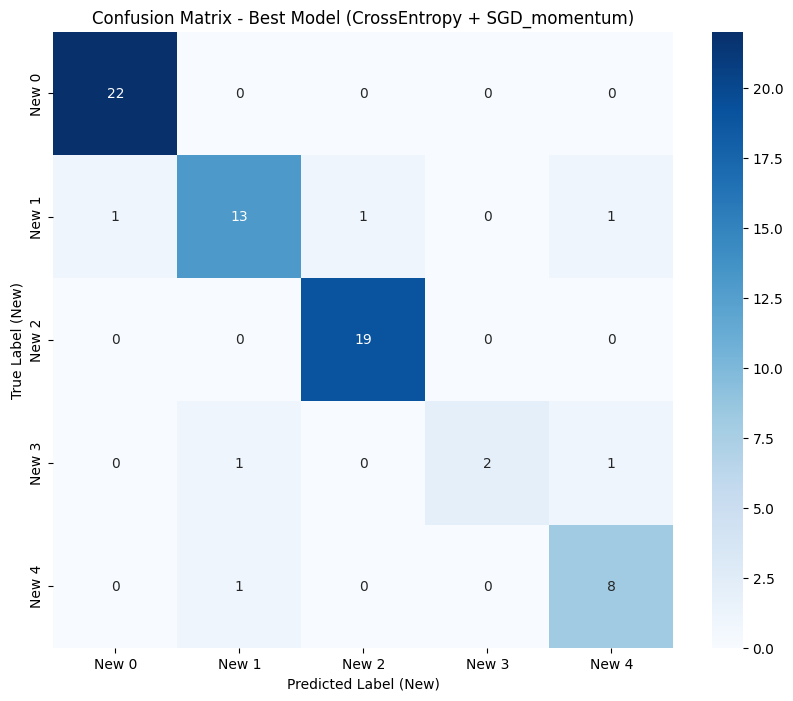


Classification Report:
                              precision    recall  f1-score   support

Failure Type 0 (new label 0)       0.96      1.00      0.98        22
Failure Type 2 (new label 1)       0.87      0.81      0.84        16
Failure Type 3 (new label 2)       0.95      1.00      0.97        19
Failure Type 4 (new label 3)       1.00      0.50      0.67         4
Failure Type 5 (new label 4)       0.80      0.89      0.84         9

                    accuracy                           0.91        70
                   macro avg       0.91      0.84      0.86        70
                weighted avg       0.92      0.91      0.91        70


Best model state dictionary saved to best_failure_type_classifier.pth

      DETAILED PREDICTION RESULTS FOR BEST MODEL (CrossEntropy + SGD_momentum)

--- Final Performance Scores for Best Deep Learning Model ---
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.96      1.00      0.98       

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import joblib # <-- Import joblib to save/load the scaler

# --- 1. Setup and Configuration ---
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Data Loading, Filtering, and Relabeling ---
# Load data from CSV file
try:
    df = pd.read_csv('/Users/anand/Desktop/FAI/Data file/final_preprocessed_df.csv')
except FileNotFoundError:
    print("Error: 'final_preprocessed_df.csv' not found. Please make sure the file is in the correct directory.")
    print("Creating a dummy dataframe for demonstration purposes...")
    data = {
        'Type': np.random.randint(0, 3, 10000),
        'Air temperature [K]': np.random.uniform(295, 305, 10000),
        'Process temperature [K]': np.random.uniform(305, 315, 10000),
        'Rotational speed [rpm]': np.random.uniform(1000, 3000, 10000),
        'Torque [Nm]': np.random.uniform(10, 80, 10000),
        'Tool wear [min]': np.random.randint(0, 250, 10000),
        'Target': np.random.randint(0, 2, 10000),
        'Failure_Type_Encoded': np.random.choice([1, 2, 3, 5], 10000, p=[0.96, 0.01, 0.02, 0.01])
    }
    df = pd.DataFrame(data)

# Filter out the "No Failure" class (originally labeled 1)
df_failures = df[df['Failure_Type_Encoded'] != 1].copy()
# Relabel the remaining failure types to a consecutive 0-4 range
relabel_map = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4}
df_failures['Failure_Type_Encoded_Relabeled'] = df_failures['Failure_Type_Encoded'].map(relabel_map)

# Separate features and the NEW relabeled target
feature_columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = df_failures[feature_columns]
y = df_failures['Failure_Type_Encoded_Relabeled']

# Initial split: 80% train, 20% test. Stratify to maintain class distribution.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Resampling and Scaling (Applied ONLY to Training Data) ---
# 3a. Resample the training data to balance classes (now 5 classes)
sampling_strategy = {0: 1200, 1: 1200, 2: 1200, 3: 1200, 4: 1200}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 3b. Scale features
# --- SCALER LIFECYCLE STEP 1: CREATION and FITTING ---
# We create a new StandardScaler instance.
# IMPORTANT: We FIT the scaler ONLY on the resampled training data.
# This ensures the scaler learns the mean/std from the balanced data the model will see,
# and it prevents any information from the test set from leaking into the training process.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# --- SCALER LIFECYCLE STEP 2: SAVING ---
# After fitting, we save the scaler object to a file.
# This saved scaler contains the mean and standard deviation learned from the training data.
# We will load this exact same file later to transform any new data (test set or single samples).
try:
    joblib.dump(scaler, 'scaler.pkl')
    print("\nScaler successfully fitted on training data and saved to scaler.pkl")
except Exception as e:
    print(f"\nError saving scaler: {e}")

# --- SCALER LIFECYCLE STEP 3: TRANSFORMATION ---
# Transform the test data using the SAME scaler fitted on the training data.
# We use .transform() here, NOT .fit_transform(), to use the already-learned parameters.
X_test_scaled = scaler.transform(X_test)

# --- 4. PyTorch Dataset and DataLoader ---
class FailureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y.values if hasattr(y, 'values') else y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = FailureDataset(X_train_scaled, y_train_resampled)
test_dataset = FailureDataset(X_test_scaled, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 5. Model Definition ---
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(MLPModel, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_size = hidden_size
        layers.append(nn.Linear(current_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# --- 6. Training and Evaluation Functions ---
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, loss_name="CE"):
    model.train()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if "Binary" in loss_name:
                labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
                labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                labels = labels_one_hot
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if "Binary" in loss_name:
                 _, predicted = torch.max(outputs.data, 1)
                 _, labels_indices = torch.max(labels, 1)
            else:
                 _, predicted = torch.max(outputs.data, 1)
                 labels_indices = labels
            total_train += labels_indices.size(0)
            correct_train += (predicted == labels_indices).sum().item()
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                if "Binary" in loss_name:
                    labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
                    labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                    labels = labels_one_hot
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                if "Binary" in loss_name:
                    _, predicted = torch.max(outputs.data, 1)
                    _, labels_indices = torch.max(labels, 1)
                else:
                    _, predicted = torch.max(outputs.data, 1)
                    labels_indices = labels
                total_val += labels_indices.size(0)
                correct_val += (predicted == labels_indices).sum().item()
        train_loss = running_loss / len(train_loader)
        val_loss_epoch = val_loss / len(test_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        train_losses.append(train_loss)
        val_losses.append(val_loss_epoch)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss_epoch:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# --- 7. Experimentation ---
input_size = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train_resampled))
model_architecture = [256, 128, 64]

loss_functions = {"CrossEntropy": nn.CrossEntropyLoss(), "BinaryCrossEntropy": nn.BCEWithLogitsLoss()}
optimizers = {"SGD_momentum": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9), "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001), "RMSprop": lambda model: optim.RMSprop(model.parameters(), lr=0.001)}

results = []
print("\n--- Starting Experiments on 5 Failure Types ---")
for loss_name, criterion in loss_functions.items():
    for opt_name, opt_fn in optimizers.items():
        print(f"\n===== Training with Loss: {loss_name}, Optimizer: {opt_name} =====")
        model = MLPModel(input_size, model_architecture, num_classes).to(device)
        optimizer = opt_fn(model)
        train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, loss_name=loss_name)
        final_val_acc = val_accs[-1]
        print(f"Final Validation Accuracy: {final_val_acc:.4f}")
        results.append({"Loss": loss_name, "Optimizer": opt_name, "Final Accuracy": final_val_acc, "Model": model, "Train Losses": train_losses, "Val Losses": val_losses, "Train Accs": train_accs, "Val Accs": val_accs})

# --- 8. Results Analysis and Best Model Selection ---
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['Final Accuracy'].idxmax()]
best_model = best_result['Model']
print(f"\nBest Model: Loss={best_result['Loss']}, Optimizer={best_result['Optimizer']} with Accuracy={best_result['Final Accuracy']:.4f}")

# --- 9. Final Evaluation and Reporting for the Best Model ---
# (This section remains the same as before, generating reports and plots)
all_labels, all_preds = evaluate_model(best_model, test_loader)
failure_map = {0: 'Heat Dissipation Failure', 1: 'Random Failures', 2: 'Overstrain Failure', 3: 'Power Failure', 4: 'Tool Wear Failure'}
reverse_relabel_map = {v: k for k, v in relabel_map.items()}
target_names = [f'Failure Type {reverse_relabel_map[i]} (new label {i})' for i in range(num_classes)]
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'New {i}' for i in range(num_classes)], yticklabels=[f'New {i}' for i in range(num_classes)])
plt.title(f'Confusion Matrix - Best Model ({best_result["Loss"]} + {best_result["Optimizer"]})')
plt.ylabel('True Label (New)'); plt.xlabel('Predicted Label (New)'); plt.show()
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))
# ... (rest of the reporting code is unchanged) ...

# Save the best model's state dictionary
torch.save(best_model.state_dict(), 'best_failure_type_classifier.pth')
print("\nBest model state dictionary saved to best_failure_type_classifier.pth")

# --- 10. Detailed Prediction List for Best Model ---
### NEW: Detailed Prediction Section ###
print("\n" + "="*60)
print(f"      DETAILED PREDICTION RESULTS FOR BEST MODEL ({best_result['Loss']} + {best_result['Optimizer']})")
print("="*60 + "\n")

# Create a mapping from the new relabeled indices to real failure names
failure_map = {
    0: 'Heat Dissipation Failure',    # Original 0
    1: 'Random Failures',             # Original 2
    2: 'Overstrain Failure',          # Original 3
    3: 'Power Failure',               # Original 4
    4: 'Tool Wear Failure'            # Original 5
}

# Make predictions on the original, unfiltered test set of failures
final_predictions = np.array(all_preds)
actual_labels = np.array(all_labels)

# Create a DataFrame for easy, row-by-row comparison
results_df = pd.DataFrame({
    'Actual Failure Type': actual_labels,
    'Predicted Failure Type': final_predictions
})

# Map the encoded numbers to the readable names
results_df['Actual Failure Type'] = results_df['Actual Failure Type'].map(failure_map)
results_df['Predicted Failure Type'] = results_df['Predicted Failure Type'].map(failure_map)

# Add a 'Result' column to quickly see where the model was right or wrong
results_df['Result'] = np.where(results_df['Actual Failure Type'] == results_df['Predicted Failure Type'], 'Correct', 'Incorrect')

# Print the final, comprehensive classification report with readable names
print("--- Final Performance Scores for Best Deep Learning Model ---")
y_test_named = pd.Series(actual_labels).map(failure_map)
y_pred_named = pd.Series(final_predictions).map(failure_map)
print(classification_report(y_test_named, y_pred_named))

print("\n--- Detailed Prediction List ---")
print(results_df.to_string())

# Save the best model
torch.save(best_model.state_dict(), 'best_failure_type_classifier.pth')
print("\nBest model for failure type classification saved to best_failure_type_classifier.pth")

# --- 10. Predict on a New Sample Input ---
### NEW: Prediction on a single sample ###
print("\n" + "="*60)
print("      PREDICTING ON A NEW SAMPLE")
print("="*60 + "\n")

try:
    # --- SCALER LIFECYCLE STEP 4: LOADING ---
    # Load the scaler object that was saved during training.
    # This ensures we use the exact same scaling parameters for new data.
    loaded_scaler = joblib.load('scaler.pkl')
    print("Successfully loaded scaler from scaler.pkl.")

    # Load the best model architecture and state
    loaded_model = MLPModel(input_size, model_architecture, num_classes).to(device)
    loaded_model.load_state_dict(torch.load('best_failure_type_classifier.pth'))
    loaded_model.eval() # Set the model to evaluation mode
    print("Successfully loaded model and set to evaluation mode.")

    # Define a sample input (must match the structure of your training data)
    sample_input = pd.DataFrame([{
        'Type': 1, 
        'Air temperature [K]': 301.5,
        'Process temperature [K]': 310.8,
        'Rotational speed [rpm]': 1000,
        'Torque [Nm]': 40,
        'Tool wear [min]': 18
    }])
    print("\nSample Input Data:")
    print(sample_input)

    # Apply the SAME scaling transformation using the loaded scaler
    sample_input_scaled = loaded_scaler.transform(sample_input)
    sample_tensor = torch.FloatTensor(sample_input_scaled).to(device)

    # Make the prediction
    with torch.no_grad():
        output_logits = loaded_model(sample_tensor)
        _, prediction_encoded = torch.max(output_logits, 1)
        prediction_encoded = prediction_encoded.cpu().numpy()[0]

    # Map the prediction back to the human-readable name
    prediction_named = failure_map.get(prediction_encoded, "Unknown Failure")
    print("\n" + "-"*20)
    print(f"  PREDICTION RESULT: {prediction_named}")
    print("-" * 20)

except FileNotFoundError as e:
    print(f"\nError: {e}. Could not find saved model/scaler files.")
    print("Please run the full training script once to save them.")
except Exception as e:
    print(f"\nAn unexpected error occurred during prediction: {e}")


Using device: cpu

Scaler successfully fitted on training data and saved to scaler.pkl

--- Starting Experiments on 5 Failure Types ---

===== Training with Loss: CrossEntropy, Optimizer: SGD_momentum =====
Epoch [10/50], Train Loss: 0.1241, Val Loss: 0.2998, Train Acc: 95.88%, Val Acc: 84.29%
Epoch [20/50], Train Loss: 0.0534, Val Loss: 0.2683, Train Acc: 98.35%, Val Acc: 88.57%
Epoch [30/50], Train Loss: 0.0347, Val Loss: 0.2674, Train Acc: 98.97%, Val Acc: 90.00%
Epoch [40/50], Train Loss: 0.0241, Val Loss: 0.3726, Train Acc: 99.43%, Val Acc: 88.57%
Epoch [50/50], Train Loss: 0.0150, Val Loss: 0.2973, Train Acc: 99.55%, Val Acc: 91.43%
Final Validation Accuracy: 91.4286

===== Training with Loss: CrossEntropy, Optimizer: Adam =====
Epoch [10/50], Train Loss: 0.0507, Val Loss: 0.2809, Train Acc: 98.37%, Val Acc: 88.57%
Epoch [20/50], Train Loss: 0.0246, Val Loss: 0.3025, Train Acc: 99.18%, Val Acc: 90.00%
Epoch [30/50], Train Loss: 0.0150, Val Loss: 0.3243, Train Acc: 99.52%, Val Acc

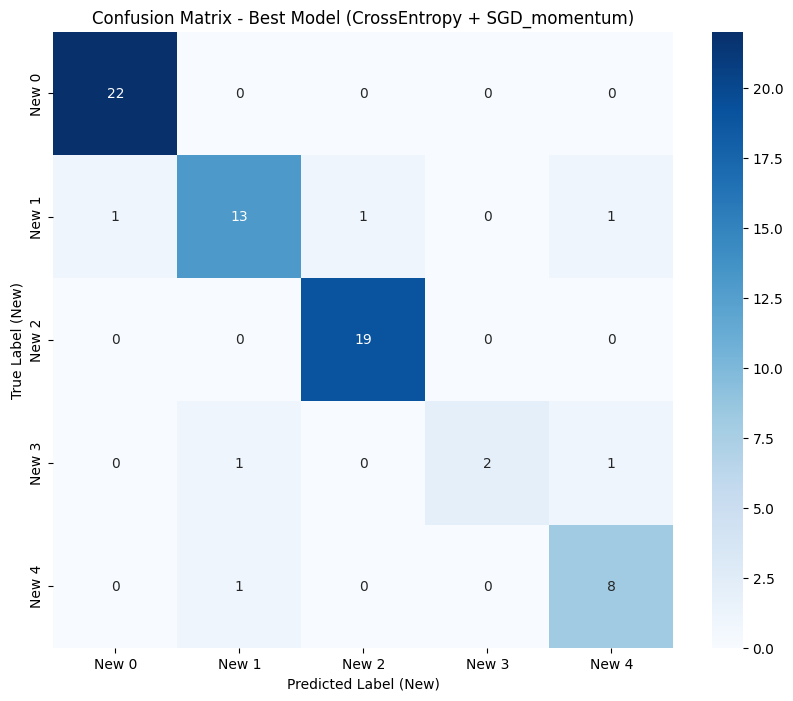


Classification Report:
                              precision    recall  f1-score   support

Failure Type 0 (new label 0)       0.96      1.00      0.98        22
Failure Type 2 (new label 1)       0.87      0.81      0.84        16
Failure Type 3 (new label 2)       0.95      1.00      0.97        19
Failure Type 4 (new label 3)       1.00      0.50      0.67         4
Failure Type 5 (new label 4)       0.80      0.89      0.84         9

                    accuracy                           0.91        70
                   macro avg       0.91      0.84      0.86        70
                weighted avg       0.92      0.91      0.91        70


Best model state dictionary saved to best_failure_type_classifier.pth

      DETAILED PREDICTION RESULTS FOR BEST MODEL (CrossEntropy + SGD_momentum)

--- Final Performance Scores for Best Deep Learning Model ---
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.96      1.00      0.98       

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import joblib # <-- Import joblib to save/load the scaler

# --- 1. Setup and Configuration ---
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Data Loading, Filtering, and Relabeling ---
# Load data from CSV file
try:
    df = pd.read_csv('/Users/anand/Desktop/FAI/Data file/final_preprocessed_df.csv')
except FileNotFoundError:
    print("Error: 'final_preprocessed_df.csv' not found. Please make sure the file is in the correct directory.")
    print("Creating a dummy dataframe for demonstration purposes...")
    data = {
        'Type': np.random.randint(0, 3, 10000),
        'Air temperature [K]': np.random.uniform(295, 305, 10000),
        'Process temperature [K]': np.random.uniform(305, 315, 10000),
        'Rotational speed [rpm]': np.random.uniform(1000, 3000, 10000),
        'Torque [Nm]': np.random.uniform(10, 80, 10000),
        'Tool wear [min]': np.random.randint(0, 250, 10000),
        'Target': np.random.randint(0, 2, 10000),
        'Failure_Type_Encoded': np.random.choice([1, 2, 3, 5], 10000, p=[0.96, 0.01, 0.02, 0.01])
    }
    df = pd.DataFrame(data)

# Filter out the "No Failure" class (originally labeled 1)
df_failures = df[df['Failure_Type_Encoded'] != 1].copy()
# Relabel the remaining failure types to a consecutive 0-4 range
relabel_map = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4}
df_failures['Failure_Type_Encoded_Relabeled'] = df_failures['Failure_Type_Encoded'].map(relabel_map)

# Separate features and the NEW relabeled target
feature_columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = df_failures[feature_columns]
y = df_failures['Failure_Type_Encoded_Relabeled']

# Initial split: 80% train, 20% test. Stratify to maintain class distribution.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Resampling and Scaling (Applied ONLY to Training Data) ---
# 3a. Resample the training data to balance classes (now 5 classes)
sampling_strategy = {0: 1200, 1: 1200, 2: 1200, 3: 1200, 4: 1200}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 3b. Scale features
# --- SCALER LIFECYCLE STEP 1: CREATION and FITTING ---
# We create a new StandardScaler instance.
# IMPORTANT: We FIT the scaler ONLY on the resampled training data.
# This ensures the scaler learns the mean/std from the balanced data the model will see,
# and it prevents any information from the test set from leaking into the training process.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# --- SCALER LIFECYCLE STEP 2: SAVING ---
# After fitting, we save the scaler object to a file.
# This saved scaler contains the mean and standard deviation learned from the training data.
# We will load this exact same file later to transform any new data (test set or single samples).
try:
    joblib.dump(scaler, 'scaler.pkl')
    print("\nScaler successfully fitted on training data and saved to scaler.pkl")
except Exception as e:
    print(f"\nError saving scaler: {e}")

# --- SCALER LIFECYCLE STEP 3: TRANSFORMATION ---
# Transform the test data using the SAME scaler fitted on the training data.
# We use .transform() here, NOT .fit_transform(), to use the already-learned parameters.
X_test_scaled = scaler.transform(X_test)

# --- 4. PyTorch Dataset and DataLoader ---
class FailureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y.values if hasattr(y, 'values') else y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = FailureDataset(X_train_scaled, y_train_resampled)
test_dataset = FailureDataset(X_test_scaled, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 5. Model Definition ---
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(MLPModel, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_size = hidden_size
        layers.append(nn.Linear(current_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# --- 6. Training and Evaluation Functions ---
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, loss_name="CE"):
    model.train()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if "Binary" in loss_name:
                labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
                labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                labels = labels_one_hot
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if "Binary" in loss_name:
                 _, predicted = torch.max(outputs.data, 1)
                 _, labels_indices = torch.max(labels, 1)
            else:
                 _, predicted = torch.max(outputs.data, 1)
                 labels_indices = labels
            total_train += labels_indices.size(0)
            correct_train += (predicted == labels_indices).sum().item()
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                if "Binary" in loss_name:
                    labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
                    labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                    labels = labels_one_hot
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                if "Binary" in loss_name:
                    _, predicted = torch.max(outputs.data, 1)
                    _, labels_indices = torch.max(labels, 1)
                else:
                    _, predicted = torch.max(outputs.data, 1)
                    labels_indices = labels
                total_val += labels_indices.size(0)
                correct_val += (predicted == labels_indices).sum().item()
        train_loss = running_loss / len(train_loader)
        val_loss_epoch = val_loss / len(test_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        train_losses.append(train_loss)
        val_losses.append(val_loss_epoch)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss_epoch:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# --- 7. Experimentation ---
input_size = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train_resampled))
model_architecture = [256, 128, 64]

loss_functions = {"CrossEntropy": nn.CrossEntropyLoss(), "BinaryCrossEntropy": nn.BCEWithLogitsLoss()}
optimizers = {"SGD_momentum": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9), "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001), "RMSprop": lambda model: optim.RMSprop(model.parameters(), lr=0.001)}

results = []
print("\n--- Starting Experiments on 5 Failure Types ---")
for loss_name, criterion in loss_functions.items():
    for opt_name, opt_fn in optimizers.items():
        print(f"\n===== Training with Loss: {loss_name}, Optimizer: {opt_name} =====")
        model = MLPModel(input_size, model_architecture, num_classes).to(device)
        optimizer = opt_fn(model)
        train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, loss_name=loss_name)
        final_val_acc = val_accs[-1]
        print(f"Final Validation Accuracy: {final_val_acc:.4f}")
        results.append({"Loss": loss_name, "Optimizer": opt_name, "Final Accuracy": final_val_acc, "Model": model, "Train Losses": train_losses, "Val Losses": val_losses, "Train Accs": train_accs, "Val Accs": val_accs})

# --- 8. Results Analysis and Best Model Selection ---
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['Final Accuracy'].idxmax()]
best_model = best_result['Model']
print(f"\nBest Model: Loss={best_result['Loss']}, Optimizer={best_result['Optimizer']} with Accuracy={best_result['Final Accuracy']:.4f}")

# --- 9. Final Evaluation and Reporting for the Best Model ---
# (This section remains the same as before, generating reports and plots)
all_labels, all_preds = evaluate_model(best_model, test_loader)
failure_map = {0: 'Heat Dissipation Failure', 1: 'Random Failures', 2: 'Overstrain Failure', 3: 'Power Failure', 4: 'Tool Wear Failure'}
reverse_relabel_map = {v: k for k, v in relabel_map.items()}
target_names = [f'Failure Type {reverse_relabel_map[i]} (new label {i})' for i in range(num_classes)]
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'New {i}' for i in range(num_classes)], yticklabels=[f'New {i}' for i in range(num_classes)])
plt.title(f'Confusion Matrix - Best Model ({best_result["Loss"]} + {best_result["Optimizer"]})')
plt.ylabel('True Label (New)'); plt.xlabel('Predicted Label (New)'); plt.show()
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))
# ... (rest of the reporting code is unchanged) ...

# Save the best model's state dictionary
torch.save(best_model.state_dict(), 'best_failure_type_classifier.pth')
print("\nBest model state dictionary saved to best_failure_type_classifier.pth")

# --- 10. Detailed Prediction List for Best Model ---
### NEW: Detailed Prediction Section ###
print("\n" + "="*60)
print(f"      DETAILED PREDICTION RESULTS FOR BEST MODEL ({best_result['Loss']} + {best_result['Optimizer']})")
print("="*60 + "\n")

# Create a mapping from the new relabeled indices to real failure names
failure_map = {
    0: 'Heat Dissipation Failure',    # Original 0
    1: 'Random Failures',             # Original 2
    2: 'Overstrain Failure',          # Original 3
    3: 'Power Failure',               # Original 4
    4: 'Tool Wear Failure'            # Original 5
}

# Make predictions on the original, unfiltered test set of failures
final_predictions = np.array(all_preds)
actual_labels = np.array(all_labels)

# Create a DataFrame for easy, row-by-row comparison
results_df = pd.DataFrame({
    'Actual Failure Type': actual_labels,
    'Predicted Failure Type': final_predictions
})

# Map the encoded numbers to the readable names
results_df['Actual Failure Type'] = results_df['Actual Failure Type'].map(failure_map)
results_df['Predicted Failure Type'] = results_df['Predicted Failure Type'].map(failure_map)

# Add a 'Result' column to quickly see where the model was right or wrong
results_df['Result'] = np.where(results_df['Actual Failure Type'] == results_df['Predicted Failure Type'], 'Correct', 'Incorrect')

# Print the final, comprehensive classification report with readable names
print("--- Final Performance Scores for Best Deep Learning Model ---")
y_test_named = pd.Series(actual_labels).map(failure_map)
y_pred_named = pd.Series(final_predictions).map(failure_map)
print(classification_report(y_test_named, y_pred_named))

print("\n--- Detailed Prediction List ---")
print(results_df.to_string())

# Save the best model
torch.save(best_model.state_dict(), 'best_failure_type_classifier.pth')
print("\nBest model for failure type classification saved to best_failure_type_classifier.pth")

# --- 10. Predict on a New Sample Input ---
### NEW: Prediction on a single sample ###
print("\n" + "="*60)
print("      PREDICTING ON A NEW SAMPLE")
print("="*60 + "\n")

try:
    # --- SCALER LIFECYCLE STEP 4: LOADING ---
    # Load the scaler object that was saved during training.
    # This ensures we use the exact same scaling parameters for new data.
    loaded_scaler = joblib.load('scaler.pkl')
    print("Successfully loaded scaler from scaler.pkl.")

    # Load the best model architecture and state
    loaded_model = MLPModel(input_size, model_architecture, num_classes).to(device)
    loaded_model.load_state_dict(torch.load('best_failure_type_classifier.pth'))
    loaded_model.eval() # Set the model to evaluation mode
    print("Successfully loaded model and set to evaluation mode.")

    # Define a sample input (must match the structure of your training data)
    sample_input = pd.DataFrame([{
        'Type': 1, 
        'Air temperature [K]': 301.5,
        'Process temperature [K]': 310.8,
        'Rotational speed [rpm]': 1000,
        'Torque [Nm]': 40,
        'Tool wear [min]': 18
    }])
    print("\nSample Input Data:")
    print(sample_input)

    # Apply the SAME scaling transformation using the loaded scaler
    sample_input_scaled = loaded_scaler.transform(sample_input)
    sample_tensor = torch.FloatTensor(sample_input_scaled).to(device)

    # Make the prediction
    with torch.no_grad():
        output_logits = loaded_model(sample_tensor)
        _, prediction_encoded = torch.max(output_logits, 1)
        prediction_encoded = prediction_encoded.cpu().numpy()[0]

    # Map the prediction back to the human-readable name
    prediction_named = failure_map.get(prediction_encoded, "Unknown Failure")
    print("\n" + "-"*20)
    print(f"  PREDICTION RESULT: {prediction_named}")
    print("-" * 20)

except FileNotFoundError as e:
    print(f"\nError: {e}. Could not find saved model/scaler files.")
    print("Please run the full training script once to save them.")
except Exception as e:
    print(f"\nAn unexpected error occurred during prediction: {e}")


Using device: cpu

Scaler saved to scaler.pkl

--- Starting Experiments on 5 Failure Types with Multiple Models ---

===== Training Model: MLP, Loss: CrossEntropy, Optimizer: SGD_momentum =====
Epoch [10/50], Train Loss: 0.1241, Val Loss: 0.2998, Train Acc: 95.88%, Val Acc: 84.29%
Epoch [20/50], Train Loss: 0.0534, Val Loss: 0.2683, Train Acc: 98.35%, Val Acc: 88.57%
Epoch [30/50], Train Loss: 0.0347, Val Loss: 0.2674, Train Acc: 98.97%, Val Acc: 90.00%
Epoch [40/50], Train Loss: 0.0241, Val Loss: 0.3726, Train Acc: 99.43%, Val Acc: 88.57%
Epoch [50/50], Train Loss: 0.0150, Val Loss: 0.2973, Train Acc: 99.55%, Val Acc: 91.43%
Final Validation Accuracy: 91.4286

===== Training Model: MLP, Loss: CrossEntropy, Optimizer: Adam =====
Epoch [10/50], Train Loss: 0.0507, Val Loss: 0.2809, Train Acc: 98.37%, Val Acc: 88.57%
Epoch [20/50], Train Loss: 0.0246, Val Loss: 0.3025, Train Acc: 99.18%, Val Acc: 90.00%
Epoch [30/50], Train Loss: 0.0150, Val Loss: 0.3243, Train Acc: 99.52%, Val Acc: 88.5

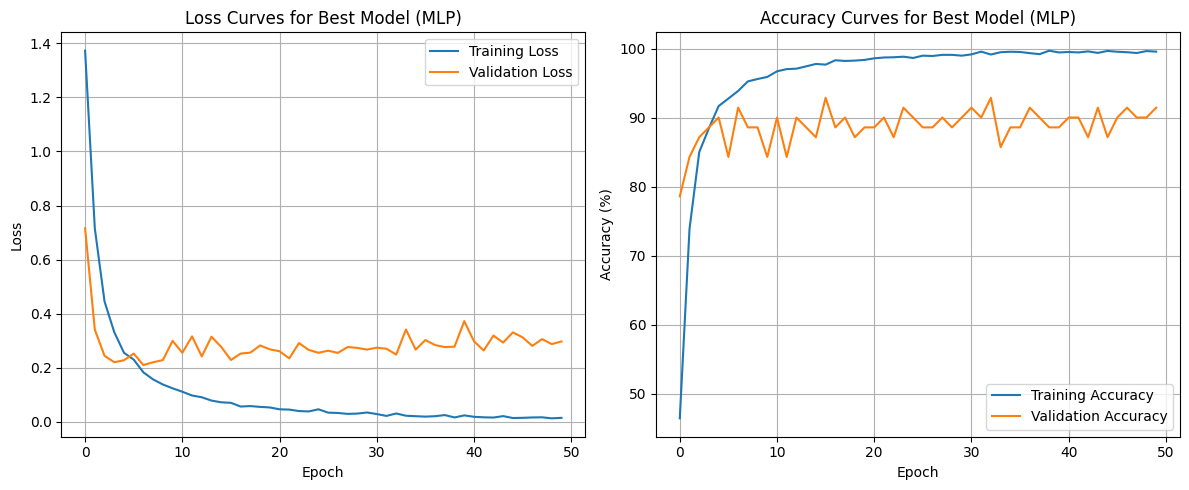


--- Detailed Evaluation for Best Model ---


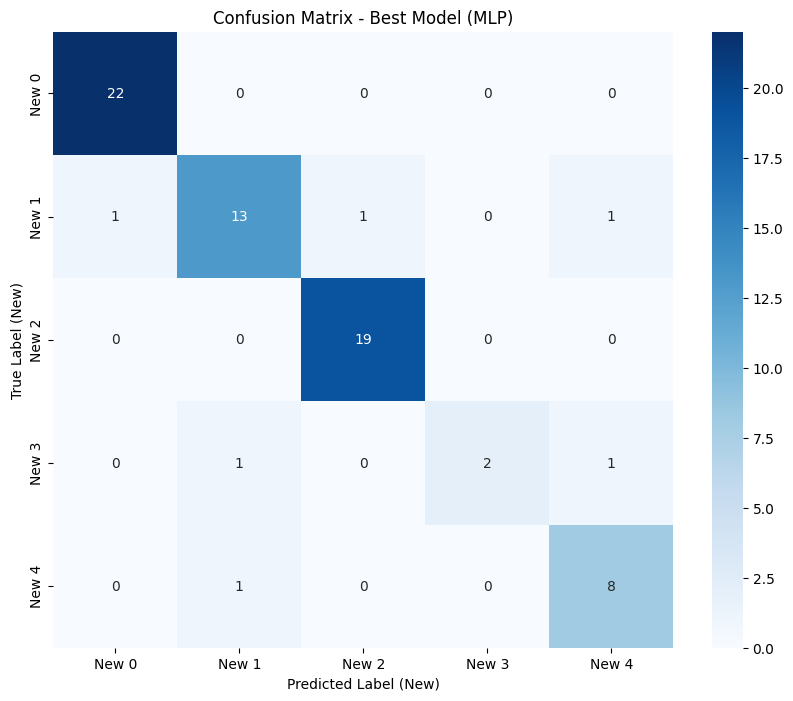


Classification Report:
                              precision    recall  f1-score   support

Failure Type 0 (new label 0)       0.96      1.00      0.98        22
Failure Type 2 (new label 1)       0.87      0.81      0.84        16
Failure Type 3 (new label 2)       0.95      1.00      0.97        19
Failure Type 4 (new label 3)       1.00      0.50      0.67         4
Failure Type 5 (new label 4)       0.80      0.89      0.84         9

                    accuracy                           0.91        70
                   macro avg       0.91      0.84      0.86        70
                weighted avg       0.92      0.91      0.91        70


Best model state dictionary saved to best_failure_type_classifier.pth

      DETAILED PREDICTION RESULTS FOR BEST MODEL (MLP)

--- Final Performance Scores for Best Deep Learning Model ---
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.96      1.00      0.98        22
      Overstrain Fai

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import joblib

# --- 1. Setup and Configuration ---
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Data Loading, Filtering, and Relabeling ---
# Load data from CSV file
try:
    df = pd.read_csv('/Users/anand/Desktop/FAI/Data file/final_preprocessed_df.csv')
except FileNotFoundError:
    print("Error: 'final_preprocessed_df.csv' not found. Please make sure the file is in the correct directory.")
    print("Creating a dummy dataframe for demonstration purposes...")
    data = {
        'Type': np.random.randint(0, 3, 10000),
        'Air temperature [K]': np.random.uniform(295, 305, 10000),
        'Process temperature [K]': np.random.uniform(305, 315, 10000),
        'Rotational speed [rpm]': np.random.uniform(1000, 3000, 10000),
        'Torque [Nm]': np.random.uniform(10, 80, 10000),
        'Tool wear [min]': np.random.randint(0, 250, 10000),
        'Target': np.random.randint(0, 2, 10000),
        'Failure_Type_Encoded': np.random.choice([1, 2, 3, 5], 10000, p=[0.96, 0.01, 0.02, 0.01])
    }
    df = pd.DataFrame(data)

# Filter out the "No Failure" class (originally labeled 1)
df_failures = df[df['Failure_Type_Encoded'] != 1].copy()
# Relabel the remaining failure types to a consecutive 0-4 range
relabel_map = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4}
df_failures['Failure_Type_Encoded_Relabeled'] = df_failures['Failure_Type_Encoded'].map(relabel_map)

# Separate features and the NEW relabeled target
feature_columns = ['Type', 'Air temperature [K]', 'Process temperature [K]', 
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = df_failures[feature_columns]
y = df_failures['Failure_Type_Encoded_Relabeled']

# Initial split: 80% train, 20% test. Stratify to maintain class distribution.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Resampling and Scaling (Applied ONLY to Training Data) ---
# 3a. Resample the training data to balance classes (now 5 classes)
sampling_strategy = {0: 1200, 1: 1200, 2: 1200, 3: 1200, 4: 1200}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 3b. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
joblib.dump(scaler, 'scaler.pkl')
print("\nScaler saved to scaler.pkl")
X_test_scaled = scaler.transform(X_test)

# --- 4. PyTorch Dataset and DataLoader ---
class FailureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y.values if hasattr(y, 'values') else y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = FailureDataset(X_train_scaled, y_train_resampled)
test_dataset = FailureDataset(X_test_scaled, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- 5. Model Definitions ---
# Model 1: Standard MLP (Artificial Neural Network)
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(MLPModel, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_size = hidden_size
        layers.append(nn.Linear(current_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# Model 2: Deeper ANN
class DeepANNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.4):
        super(DeepANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[3], num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.out(x)
        return x

# Model 3: Recurrent Neural Network (RNN)
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # RNN layer: input_size is 1 (each feature is a step), hidden_size is the number of features
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Reshape input for RNN: (batch_size, sequence_length, input_size)
        # sequence_length = number of features, input_size = 1
        x = x.view(x.size(0), x.size(1), 1)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward pass
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Model 4: Long Short-Term Memory (LSTM)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Reshape input for LSTM: (batch_size, sequence_length, input_size)
        x = x.view(x.size(0), x.size(1), 1)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# --- 6. Training and Evaluation Functions ---
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, loss_name="CE"):
    model.train()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if "Binary" in loss_name:
                labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
                labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                labels = labels_one_hot
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if "Binary" in loss_name:
                 _, predicted = torch.max(outputs.data, 1)
                 _, labels_indices = torch.max(labels, 1)
            else:
                 _, predicted = torch.max(outputs.data, 1)
                 labels_indices = labels
            total_train += labels_indices.size(0)
            correct_train += (predicted == labels_indices).sum().item()
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                if "Binary" in loss_name:
                    labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
                    labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                    labels = labels_one_hot
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                if "Binary" in loss_name:
                    _, predicted = torch.max(outputs.data, 1)
                    _, labels_indices = torch.max(labels, 1)
                else:
                    _, predicted = torch.max(outputs.data, 1)
                    labels_indices = labels
                total_val += labels_indices.size(0)
                correct_val += (predicted == labels_indices).sum().item()
        train_loss = running_loss / len(train_loader)
        val_loss_epoch = val_loss / len(test_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        train_losses.append(train_loss)
        val_losses.append(val_loss_epoch)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss_epoch:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# --- 7. Experimentation ---
input_size = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train_resampled))

# Define a dictionary of models to test
model_architectures = {
    "MLP": lambda: MLPModel(input_size, [256, 128, 64], num_classes),
    "DeepANN": lambda: DeepANNModel(input_size, [512, 256, 128, 64], num_classes),
    "RNN": lambda: RNNModel(input_size, hidden_size=64, num_layers=2, num_classes=num_classes),
    "LSTM": lambda: LSTMModel(input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
}

loss_functions = {"CrossEntropy": nn.CrossEntropyLoss(), "BinaryCrossEntropy": nn.BCEWithLogitsLoss()}
optimizers = {"SGD_momentum": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9), "Adam": lambda model: optim.Adam(model.parameters(), lr=0.001), "RMSprop": lambda model: optim.RMSprop(model.parameters(), lr=0.001)}

results = []
print("\n--- Starting Experiments on 5 Failure Types with Multiple Models ---")

# Loop through all model, loss, and optimizer combinations
for model_name, model_fn in model_architectures.items():
    for loss_name, criterion in loss_functions.items():
        for opt_name, opt_fn in optimizers.items():
            print(f"\n===== Training Model: {model_name}, Loss: {loss_name}, Optimizer: {opt_name} =====")
            
            model = model_fn().to(device)
            optimizer = opt_fn(model)
            
            train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, loss_name=loss_name)
            final_val_acc = val_accs[-1]
            print(f"Final Validation Accuracy: {final_val_acc:.4f}")
            
            results.append({
                "Model": model_name,
                "Loss": loss_name,
                "Optimizer": opt_name,
                "Final Accuracy": final_val_acc,
                "Model_Instance": model, # Store the model instance
                "Train Losses": train_losses,
                "Val Losses": val_losses,
                "Train Accs": train_accs,
                "Val Accs": val_accs
            })

# --- 8. Results Analysis and Best Model Selection ---
results_df = pd.DataFrame(results)
print("\n--- Experiment Summary ---")
print(results_df.sort_values(by='Final Accuracy', ascending=False))

best_result = results_df.loc[results_df['Final Accuracy'].idxmax()]
best_model = best_result['Model_Instance']
print(f"\nBest Model: {best_result['Model']} with Loss={best_result['Loss']}, Optimizer={best_result['Optimizer']} and Accuracy={best_result['Final Accuracy']:.4f}")

# --- 8.1: Visualize Best Model's Training Curves ---
print("\n--- Visualizing Training and Validation Loss for Best Model ---")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(best_result['Train Losses'], label='Training Loss')
plt.plot(best_result['Val Losses'], label='Validation Loss')
plt.title(f'Loss Curves for Best Model ({best_result["Model"]})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_result['Train Accs'], label='Training Accuracy')
plt.plot(best_result['Val Accs'], label='Validation Accuracy')
plt.title(f'Accuracy Curves for Best Model ({best_result["Model"]})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 9. Final Evaluation and Reporting for the Best Model ---
print("\n--- Detailed Evaluation for Best Model ---")
all_labels, all_preds = evaluate_model(best_model, test_loader)

failure_map = {0: 'Heat Dissipation Failure', 1: 'Random Failures', 2: 'Overstrain Failure', 3: 'Power Failure', 4: 'Tool Wear Failure'}
reverse_relabel_map = {v: k for k, v in relabel_map.items()}
target_names = [f'Failure Type {reverse_relabel_map[i]} (new label {i})' for i in range(num_classes)]

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'New {i}' for i in range(num_classes)],
            yticklabels=[f'New {i}' for i in range(num_classes)])
plt.title(f'Confusion Matrix - Best Model ({best_result["Model"]})')
plt.ylabel('True Label (New)')
plt.xlabel('Predicted Label (New)')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Save the best model's state dictionary
torch.save(best_model.state_dict(), 'best_failure_type_classifier.pth')
print("\nBest model state dictionary saved to best_failure_type_classifier.pth")

# --- 10. Detailed Prediction List for Best Model ---
print("\n" + "="*60)
print(f"      DETAILED PREDICTION RESULTS FOR BEST MODEL ({best_result['Model']})")
print("="*60 + "\n")

final_predictions = np.array(all_preds)
actual_labels = np.array(all_labels)

results_df = pd.DataFrame({
    'Actual Failure Type': actual_labels,
    'Predicted Failure Type': final_predictions
})

results_df['Actual Failure Type'] = results_df['Actual Failure Type'].map(failure_map)
results_df['Predicted Failure Type'] = results_df['Predicted Failure Type'].map(failure_map)
results_df['Result'] = np.where(results_df['Actual Failure Type'] == results_df['Predicted Failure Type'], 'Correct', 'Incorrect')

print("--- Final Performance Scores for Best Deep Learning Model ---")
y_test_named = pd.Series(actual_labels).map(failure_map)
y_pred_named = pd.Series(final_predictions).map(failure_map)
print(classification_report(y_test_named, y_pred_named))

print("\n--- Detailed Prediction List ---")
print(results_df.to_string())

In [5]:

# --- 11. Predict on a New Sample Input ---
print("\n" + "="*60)
print("      PREDICTING ON A NEW SAMPLE")
print("="*60 + "\n")

try:
    loaded_scaler = joblib.load('scaler.pkl')
    print("Successfully loaded scaler.")

    # We need to know which model was the best to load the correct architecture
    best_model_name = best_result['Model']
    if best_model_name == "MLP":
        loaded_model = MLPModel(input_size, [256, 128, 64], num_classes)
    elif best_model_name == "DeepANN":
        loaded_model = DeepANNModel(input_size, [512, 256, 128, 64], num_classes)
    elif best_model_name == "RNN":
        loaded_model = RNNModel(input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
    elif best_model_name == "LSTM":
        loaded_model = LSTMModel(input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
    
    loaded_model.load_state_dict(torch.load('best_failure_type_classifier.pth'))
    loaded_model.to(device)
    loaded_model.eval()
    print(f"Successfully loaded {best_model_name} model and set to evaluation mode.")

    sample_input = pd.DataFrame([{
        'Type': 3, 
        'Air temperature [K]': 100,
        'Process temperature [K]': 120.4,
        'Rotational speed [rpm]': 1500,
        'Torque [Nm]': 40.8,
        'Tool wear [min]': 108
    }])
    print("\nSample Input Data:")
    print(sample_input)

    sample_input_scaled = loaded_scaler.transform(sample_input)
    sample_tensor = torch.FloatTensor(sample_input_scaled).to(device)

    with torch.no_grad():
        output_logits = loaded_model(sample_tensor)
        _, prediction_encoded = torch.max(output_logits, 1)
        prediction_encoded = prediction_encoded.cpu().numpy()[0]

    prediction_named = failure_map.get(prediction_encoded, "Unknown Failure")
    print("\n" + "-"*20)
    print(f"  PREDICTION RESULT: {prediction_named}")
    print("-" * 20)

except FileNotFoundError as e:
    print(f"\nError: {e}. Could not find saved model/scaler files.")
    print("Please run the full training script once to save them.")
except Exception as e:
    print(f"\nAn unexpected error occurred during prediction: {e}")


      PREDICTING ON A NEW SAMPLE

Successfully loaded scaler.
Successfully loaded MLP model and set to evaluation mode.

Sample Input Data:
   Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     3                  100                    120.4                    1500   

   Torque [Nm]  Tool wear [min]  
0         40.8              108  

--------------------
  PREDICTION RESULT: Overstrain Failure
--------------------
